<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Advanced Time Series Analysis</h1>
<h1>statsmodels for Time Series</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np

import statsmodels.api as sm

import matplotlib as mpl
import matplotlib.pyplot as plt 

import scipy
from scipy.stats import pearsonr

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

statsmodels.api 0.11.1
pandas          1.0.1
autopep8        1.5
json            2.0.9
watermark       2.0.2
numpy           1.18.1
scipy           1.4.1
matplotlib      3.1.3
Sun Aug 09 2020 

CPython 3.7.3
IPython 6.2.1

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 19.5.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit
Git hash   : fdf6fd68ae612986d728efccb168bee04d25837d


Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Linear Regression

Let us load up one of the datasets from the Anscombe quartet

In [4]:
data = pd.read_csv('data/Anscombe1.dat', sep=' ', header=None)
data.columns = ['x1', 'y']

And make a quick plot

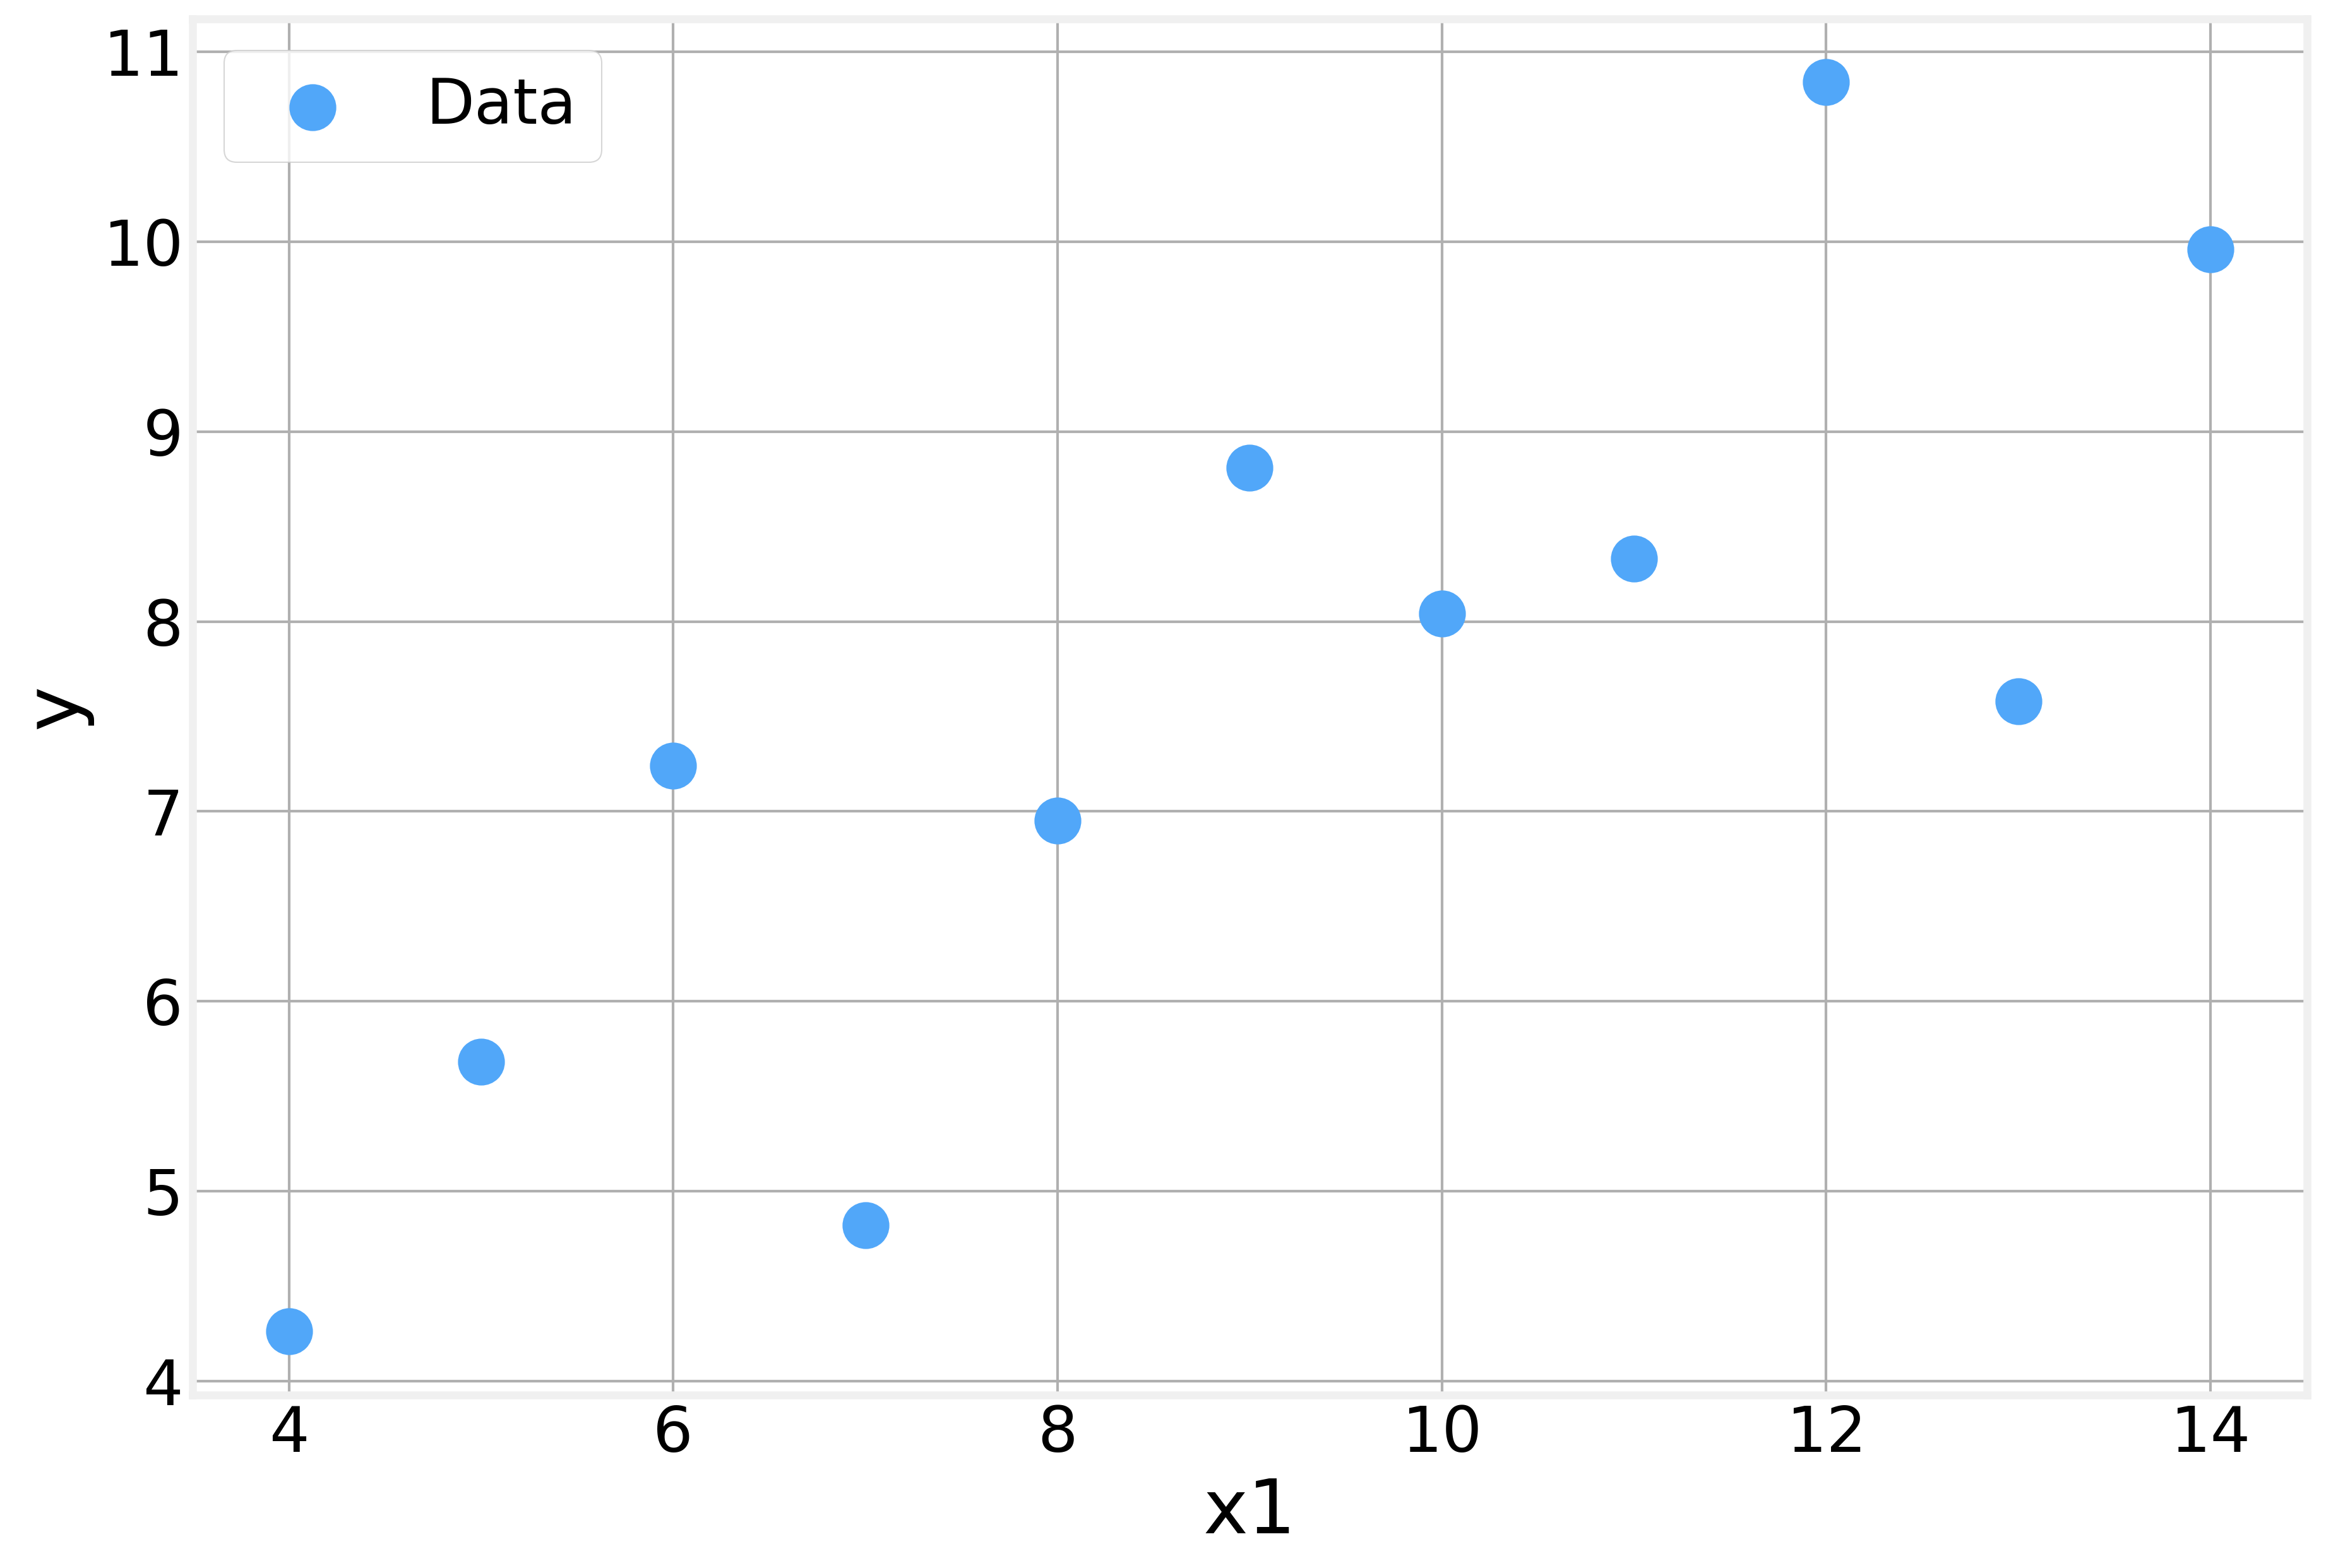

In [5]:
ax = data.plot(x='x1', y='y', kind='scatter', s=300)
ax.legend(['Data'], loc='upper left')

We'll use __statsmodels__ to perform a quick OLS to perform a Linear Regression fit. While we won't be using Linear Regressions explicitly in this lecture, many time series analysis algorithms rely on it so we include it for ease of reference. We start by explicitly adding a column of 1s for the intercept

In [6]:
data['const'] = 1

Perform the fit

In [7]:
model = sm.OLS(endog=data['y'], exog=data[['const', 'x1']])
results = model.fit()

And get a summary table of the results

In [ ]:
results.summary()

/Users/bgoncalves/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     17.99
Date:                Sun, 09 Aug 2020   Prob (F-statistic):            0.00217
Time:                        14:00:57   Log-Likelihood:                -16.841
No. Observations:                  11   AIC:                             37.68
Df Residuals:                       9   BIC:                             38.48
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0001      1.125      2.667      0.026       0.456       5.544
x1             0.5001      0.118      4.241      0.002       0.233       0.767
==============================================================================
Omnibus:                        0.082   Durbin-Watson:                   3.212
Prob(Omnibus):                  0.960   Jarque-Bera (JB):                0.289
Skew:                          -0.122   Prob(JB):                        0.865
Kurtosis:                       2.244   Cond. No.                         29.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

And calculate the model prediction for each point

In [ ]:
Y1 = results.predict(data[['const', 'x1']])

And finally plot the fitted line:

In [ ]:
ax = data.plot(x='x1', y='y', kind='scatter', s=300)
ax.plot(data['x1'], Y1, color=colors[1])
ax.legend(['Fit', 'Data'])

## Correlations

Let's load a time series to take as an example. We'll use the time series of sunspot activity

In [ ]:
Sun = pd.read_csv('data/sun.csv')

In [ ]:
Sun.set_index('YEAR').plot()

In [ ]:
sm.tsa.stattools.acf(Sun['SUNACTIVITY'])

Due to a small issue with the way statsmodels interacts with jupyter, we terminate the line with a semi-colon (or assign the output to a variable) in order to prevent double plotting.

In [ ]:
sm.graphics.tsa.plot_acf(Sun['SUNACTIVITY'], lags=40);

The corresponding partial-autocorrelation functions work in similar ways:

In [ ]:
sm.tsa.stattools.pacf(Sun['SUNACTIVITY'])

As before, we include the semi-colon

In [ ]:
sm.graphics.tsa.plot_pacf(Sun['SUNACTIVITY']);

## Dickey-Fuller test

For this example, let's load the GDP dataset

In [ ]:
GDP = pd.read_csv('data/GDP.csv', parse_dates=['DATE'], index_col=[0])
GDP.plot()

If we run the Augmented Dickey-Fuller test for the original dataset we find

In [ ]:
adf, pvalue, critical, results = sm.tsa.stattools.adfuller(GDP, regresults=True)

And in particular, the p-value makes it clear that the series is not stationary

In [ ]:
pvalue

On the other hand, if we look instead at the QoQ values:

In [ ]:
QoQ = GDP['GDP'].diff(1).dropna()
adf, pvalue, critical, results = sm.tsa.stattools.adfuller(QoQ, regresults=True)

We find a clearly significant result

In [ ]:
pvalue

Or for a more complete overview:

In [ ]:
print('ADF Statistic:', adf)
print('p-value:', pvalue)
print('Critical Values:')

for key, value in critical.items():
    print('\t%s:'% key, value)

We also obtain a lot more information in the __results__ object, like the number of lags used, how many total lags were tested, etc. In particullar

In [ ]:
print(results)
print()
for key, value in results.__dict__.items():
    if not key.startswith("_") and key not in ("resols", "critvalues", "autolag_results"):
        print("%s: %s" % (key, value))
    elif key == "critvalues":
        print("%s:" % key)
        for key2, critical_value in value.items():
            print("\t%s:" % key2, critical_value )

And the full results of the OLS linear regression:

In [ ]:
results.resols.summary()

As well as the results for each of the lags considered:

In [ ]:
results.autolag_results

## Times series decomposition

To illustrate the time series decomposition functionality of __statsmodels__, we're going to use the airline passengers dataset

In [ ]:
airline = pd.read_csv('data/international-airline-passengers.csv', sep=';', parse_dates=['Month'], index_col=0)
airline.plot()

To obtain the decomposition we must simply do:

In [ ]:
decomposition = sm.tsa.seasonal_decompose(airline, model='multiplicative', two_sided=False)

We can quickly plot the usual decomposition visualization

In [ ]:
decomposition.plot();

Each of the components is provided as a separate pandas Series for easy access and analysis

In [ ]:
decomposition.resid.tail()

And, of course, visualization

In [ ]:
decomposition.resid.plot()

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>